In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats.mstats import winsorize

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [2]:
pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('zomato.csv')

In [4]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [5]:
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [6]:
df = df.dropna(subset=['approx_cost(for two people)'])
df['cost'] = df['approx_cost(for two people)'].str.replace(',', '').astype(float)

df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7681
votes                              0
phone                            874
location                           0
rest_type                        204
dish_liked                     27868
cuisines                          19
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
cost                               0
dtype: int64

In [7]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [8]:
df.query("rate == 'NEW' or rate == '-'").count()

url                            2272
address                        2272
name                           2272
online_order                   2272
book_table                     2272
rate                           2272
votes                          2272
phone                          2259
location                       2272
rest_type                      2270
dish_liked                      147
cuisines                       2272
approx_cost(for two people)    2272
reviews_list                   2272
menu_item                      2272
listed_in(type)                2272
listed_in(city)                2272
cost                           2272
dtype: int64

In [9]:
def convert_ratings(rating):
    if (rating == 'NEW' or rating == '-'):
        return np.nan
    else:
        return float(str(rating).split('/')[0].strip())

df['converted_rating'] = df['rate'].apply(convert_ratings)

In [10]:
df['converted_rating'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, nan, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2,
       2.3, 4.8, 4.9, 2.1, 2. , 1.8])

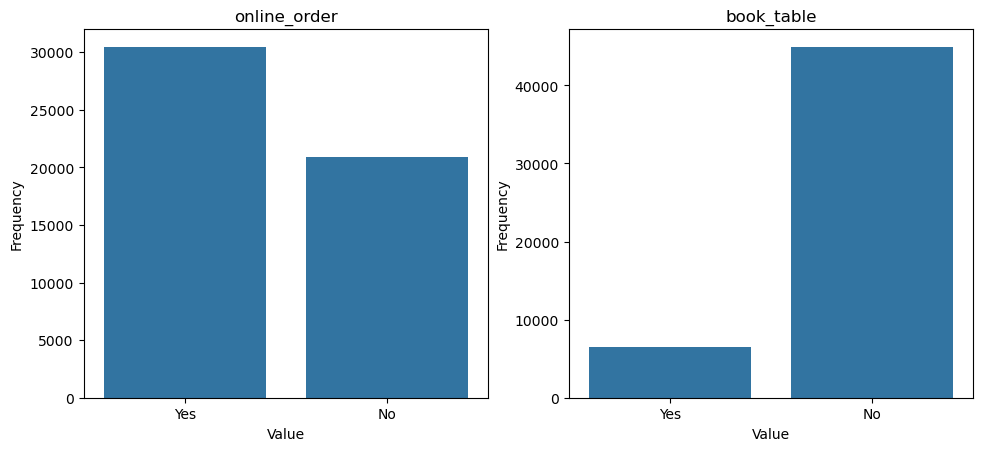

In [11]:
plt.figure(figsize=(24,22))

for i, column in enumerate(['online_order','book_table']):
    plt.subplot(4,4,i + 1)
    sns.countplot(x= df[column], data=df)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

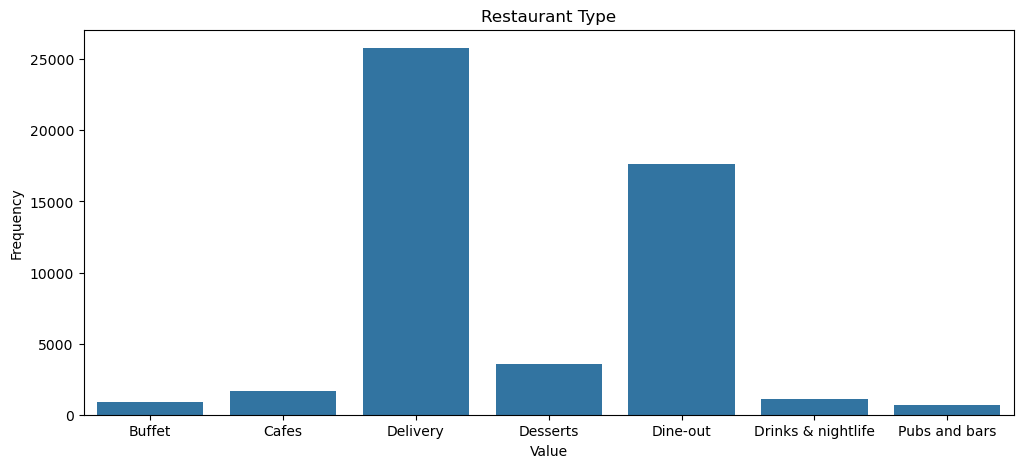

In [12]:
#for i, column in enumerate(['online_order','listed_in(type)','listed_in(city)','book_table']):
plt.figure(figsize=(12,5))
sns.countplot(x= df['listed_in(type)'], data=df)
plt.title('Restaurant Type')
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

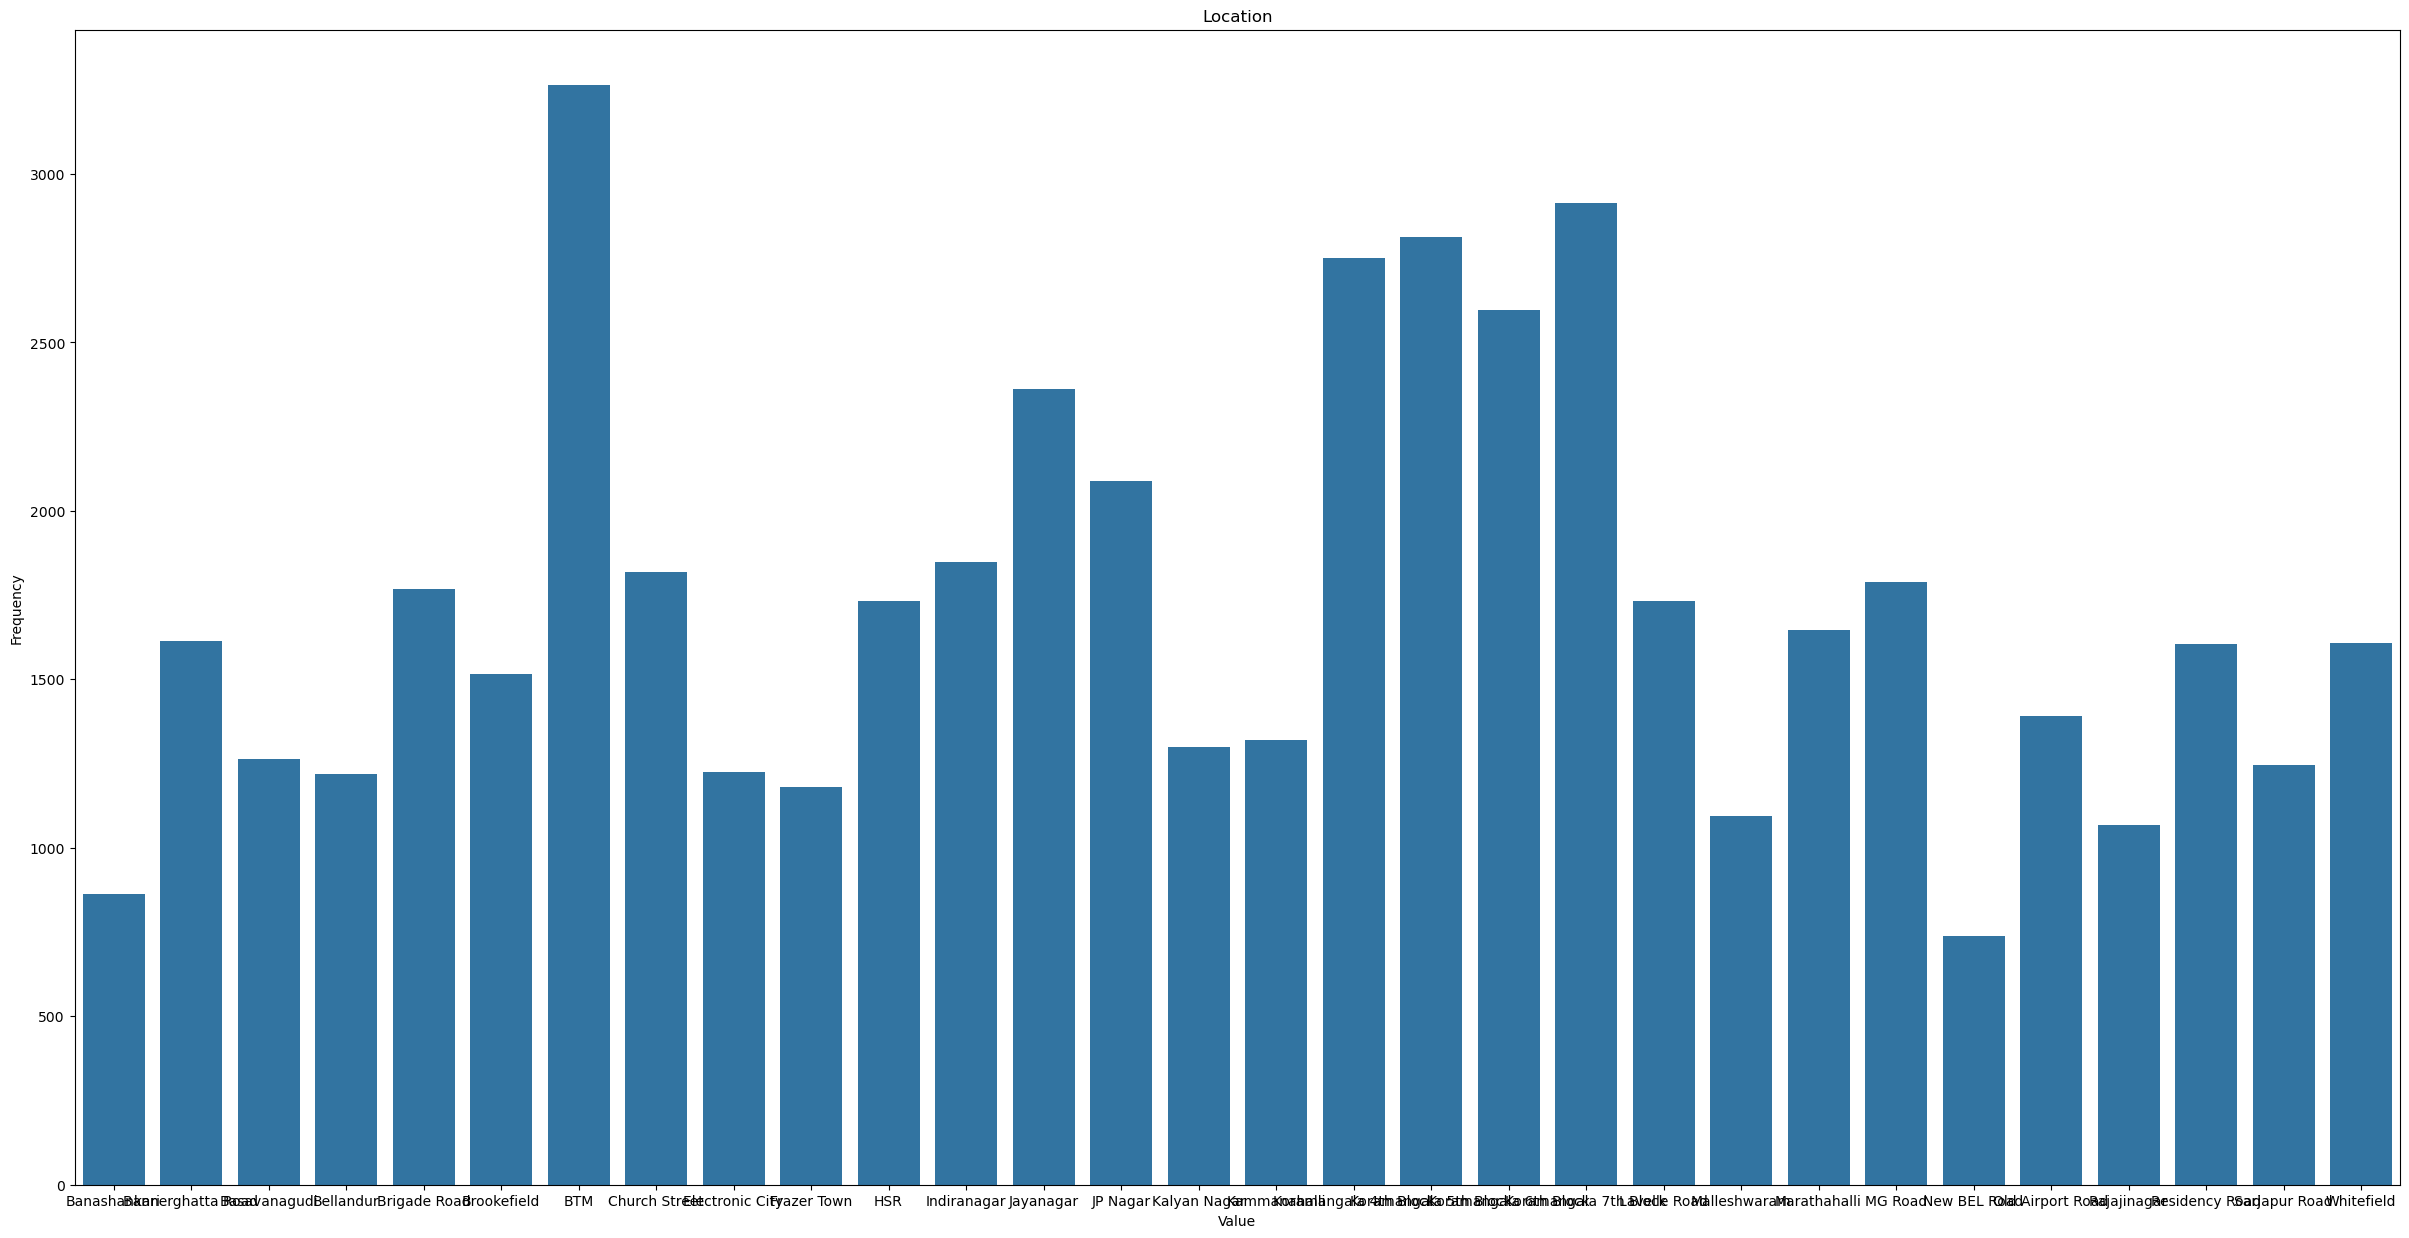

In [13]:
plt.figure(figsize=(30,15))
sns.countplot(x= df['listed_in(city)'], data=df)
plt.title('Location')
plt.xlabel('Value')
plt.ylabel('Frequency')

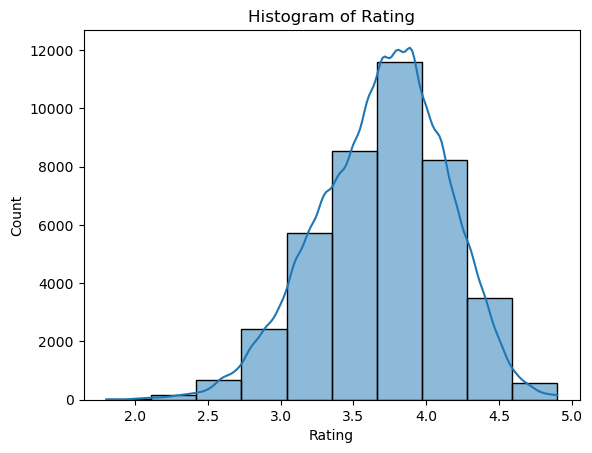

In [14]:
sns.histplot(data=df,x='converted_rating',bins=10,kde=True)
plt.title('Histogram of Rating')
plt.xlabel('Rating')
plt.show()

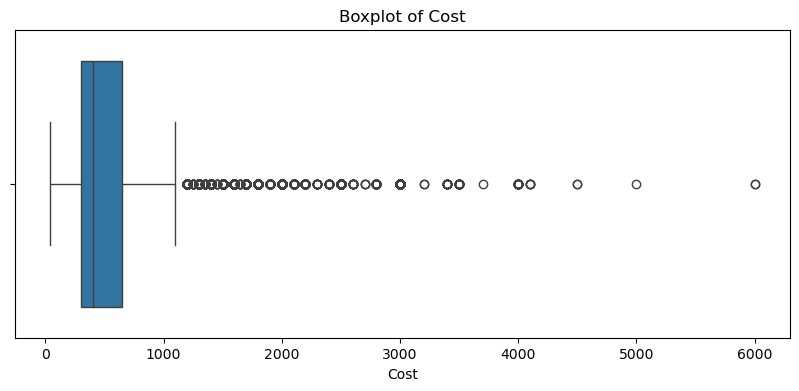

In [15]:
plt.figure(figsize=(10,4))
sns.boxplot(x= df['cost'])
plt.title('Boxplot of Cost')
plt.xlabel('Cost')
plt.show()

In [16]:
skewness = df['cost'].skew()
print(f"The skewness of the price distribution is: {skewness}")

The skewness of the price distribution is: 2.601983456428953


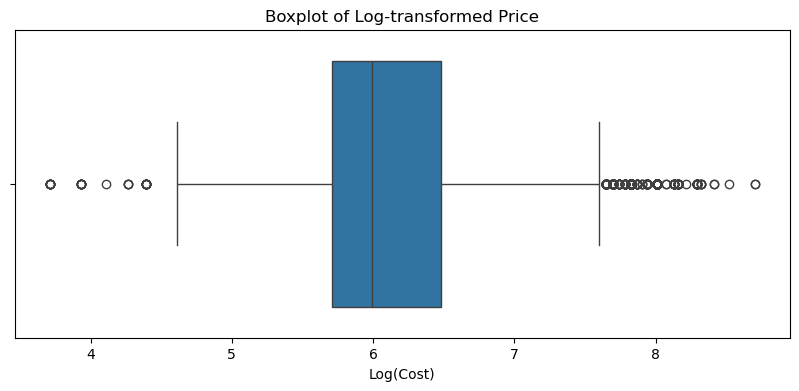

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['cost'].apply(lambda x: np.log(x+1)))
plt.title('Boxplot of Log-transformed Price')
plt.xlabel('Log(Cost)')
plt.show()

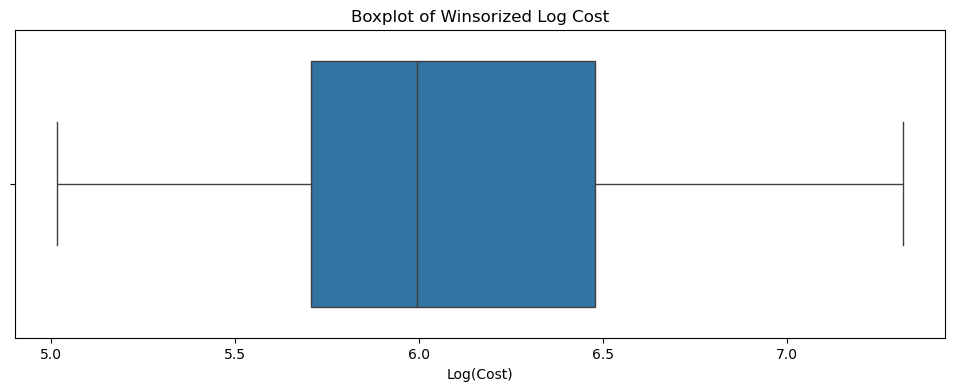

In [18]:
df['Log_Cost'] = np.log1p(df['cost'])
df['Winsorized_Log_Cost'] = winsorize(df['Log_Cost'], limits=[0.05, 0.05])

plt.figure(figsize=(12, 4))
sns.boxplot(x=df['Winsorized_Log_Cost'])
plt.title('Boxplot of Winsorized Log Cost')
plt.xlabel('Log(Cost)')
plt.show()

In [19]:
df['cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ...,
       'North Indian, Street Food, Biryani', 'Chinese, Mughlai',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [20]:
len(list(df['cuisines'].unique()))

2716

In [21]:
#Too many cuisines, we can vectorize it

df['cuisines'] = df['cuisines'].fillna('Unknown')

df['cuisine_list'] = df['cuisines'].apply(lambda x: x.split(', '))

model = Word2Vec(sentences= df['cuisine_list'], vector_size=100, window=5, min_count=1, workers=4)

cuisine_vectors = {cuisine: model.wv[cuisine] for cuisine in model.wv.index_to_key}

df['cuisine_vector'] = df['cuisine_list'].apply(lambda cuisines: np.mean([cuisine_vectors.get(cuisine, np.zeros(100)) for cuisine in cuisines], axis=0))

In [22]:
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7681
votes                              0
phone                            874
location                           0
rest_type                        204
dish_liked                     27868
cuisines                           0
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
cost                               0
converted_rating                9953
Log_Cost                           0
Winsorized_Log_Cost                0
cuisine_list                       0
cuisine_vector                     0
dtype: int64

In [23]:
#Lots of Ratings are missing, let's impute

one_hot_encoder = OneHotEncoder()
categorical_data = one_hot_encoder.fit_transform(df[['online_order', 'book_table', 'listed_in(type)', 'listed_in(city)']]).toarray()
categorical_feature_names = one_hot_encoder.get_feature_names_out(['online_order', 'book_table', 'listed_in(type)', 'listed_in(city)'])

features = np.hstack((categorical_data, df[['votes', 'Winsorized_Log_Cost']].values, df['cuisine_vector'].tolist()))
target = df['converted_rating'].values.reshape(-1, 1)

imp = IterativeImputer(estimator=LinearRegression(),random_state=0,max_iter=10,initial_strategy='mean')
imputed_ratings = imp.fit_transform(np.hstack((target, features)))

df['converted_rating'] = imputed_ratings[:, 0]

In [24]:
df.isna().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7681
votes                              0
phone                            874
location                           0
rest_type                        204
dish_liked                     27868
cuisines                           0
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
cost                               0
converted_rating                   0
Log_Cost                           0
Winsorized_Log_Cost                0
cuisine_list                       0
cuisine_vector                     0
dtype: int64

In [25]:
df = df.drop(['url','address','name','rate','reviews_list','menu_item','phone','location','rest_type','dish_liked','approx_cost(for two people)','cost','Log_Cost','cuisine_list','cuisines'], axis = 1)

In [26]:
df.head()

,online_order,book_table,votes,listed_in(type),listed_in(city),converted_rating,Winsorized_Log_Cost,cuisine_vector
0,Yes,Yes,775,Buffet,Banashankari,4.1,6.685861,"[-0.106578566, 0.09952705, -0.04808973, 0.1630..."
1,Yes,No,787,Buffet,Banashankari,4.1,6.685861,"[-0.1661128, 0.059672993, -0.03301237, 0.21210..."
2,Yes,No,918,Buffet,Banashankari,3.8,6.685861,"[-0.17971642, 0.05172697, 0.21729143, 0.278058..."
3,No,No,88,Buffet,Banashankari,3.7,5.707110,"[-0.039370086, 0.043032907, -0.08050926, 0.206..."
4,No,No,166,Buffet,Banashankari,3.8,6.398595,"[-0.03947616, 0.09066195, -0.020755937, 0.2556..."


/tmp/ipykernel_1573001/2537442134.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f')


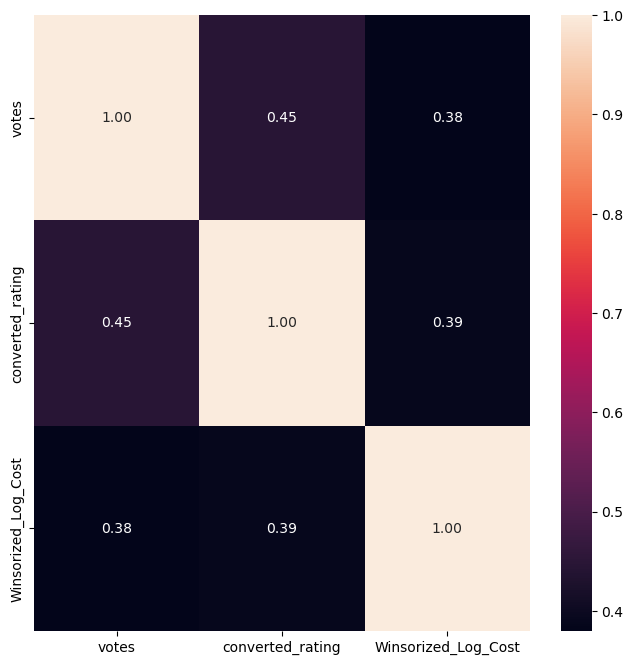

In [27]:
plt.figure(figsize = (8,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

In [28]:
correlation_matrix = df.corr()
target_correlations = correlation_matrix['Winsorized_Log_Cost']
print(target_correlations)

votes                  0.379518
converted_rating       0.387113
Winsorized_Log_Cost    1.000000
Name: Winsorized_Log_Cost, dtype: float64


/tmp/ipykernel_1573001/2907905056.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [29]:
cols_cat = ['online_order','book_table','listed_in(type)','listed_in(city)']

print("Observing the categorical column disribution before encoding: \n")
for columns in cols_cat:
    print(columns, '\n')
    print(df[columns].value_counts(),'\n')

Observing the categorical column disribution before encoding: 

online_order 

Yes    30444
No     20927
Name: online_order, dtype: int64 

book_table 

No     44922
Yes     6449
Name: book_table, dtype: int64 

listed_in(type) 

Delivery              25786
Dine-out              17664
Desserts               3568
Cafes                  1703
Drinks & nightlife     1091
Buffet                  871
Pubs and bars           688
Name: listed_in(type), dtype: int64 

listed_in(city) 

BTM                      3265
Koramangala 7th Block    2914
Koramangala 5th Block    2813
Koramangala 4th Block    2752
Koramangala 6th Block    2596
Jayanagar                2362
JP Nagar                 2088
Indiranagar              1847
Church Street            1819
MG Road                  1788
Brigade Road             1767
HSR                      1734
Lavelle Road             1732
Marathahalli             1646
Bannerghatta Road        1614
Whitefield               1607
Residency Road           1604
Brookefi

In [30]:
encoder = LabelEncoder()
for columns in cols_cat:
    df[columns] = encoder.fit_transform(df[columns])

print("Observing the categorical column disribution after encoding: \n")
for columns in cols_cat:
    print(columns, '\n')
    print(df[columns].value_counts(),'\n')

Observing the categorical column disribution after encoding: 

online_order 

1    30444
0    20927
Name: online_order, dtype: int64 

book_table 

0    44922
1     6449
Name: book_table, dtype: int64 

listed_in(type) 

2    25786
4    17664
3     3568
1     1703
5     1091
0      871
6      688
Name: listed_in(type), dtype: int64 

listed_in(city) 

0     3265
19    2914
17    2813
16    2752
18    2596
13    2362
12    2088
11    1847
7     1819
21    1788
5     1767
10    1734
20    1732
23    1646
2     1614
29    1607
27    1604
6     1516
25    1390
15    1319
14    1299
3     1265
28    1246
8     1225
4     1220
9     1180
22    1094
26    1069
1      863
24     737
Name: listed_in(city), dtype: int64 



In [31]:
base_array = df.drop(['cuisine_vector','Winsorized_Log_Cost'], axis=1).to_numpy()

cuisine_array = np.array(df['cuisine_vector'].tolist())

X_reg = np.hstack((base_array, cuisine_array))

In [32]:
X_reg

array([[ 1.00000000e+00,  1.00000000e+00,  7.75000000e+02, ...,
        -7.12482482e-02, -1.56493768e-01,  6.81040287e-02],
       [ 1.00000000e+00,  0.00000000e+00,  7.87000000e+02, ...,
        -1.30326644e-01, -9.90939513e-02,  1.17475830e-01],
       [ 1.00000000e+00,  0.00000000e+00,  9.18000000e+02, ...,
         7.38181099e-02,  2.97132760e-01,  2.12293252e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.47659463e-02,  1.03940591e-01,  2.62875140e-01],
       [ 0.00000000e+00,  1.00000000e+00,  2.36000000e+02, ...,
         9.47659463e-02,  1.03940591e-01,  2.62875140e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.30000000e+01, ...,
        -1.38949342e-02,  1.08678840e-01,  1.93697810e-01]])

In [33]:
y_reg = df['Winsorized_Log_Cost'].to_numpy()

In [34]:
y_reg

array([6.68586095, 6.68586095, 6.68586095, ..., 7.31388683, 7.31388683,
       7.31388683])

In [35]:
reg_models = {
     'Linear Regression': LinearRegression(),
     'Ridge Regression': Ridge(alpha=1.0),
     'Random Forest Regression': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [36]:
def blb_regression_metrics(X, y, model, resample_size, num_subsamples, num_resamples, ci_level=0.95):
    n = len(X)
    metrics = {'CI Width': [], 'Coverage': [], 'Bias': [], 'MSE': []}
    
    for i in range(num_subsamples):
        indices = np.random.choice(n, resample_size, replace=False)
        X_subsample, y_subsample = X[indices], y[indices]
        model_subsample = model.fit(X_subsample, y_subsample)
        original_estimate = model_subsample.predict(X_subsample)
        
        bootstrap_estimates = np.zeros((num_resamples, resample_size))
        for j in range(num_resamples):
            resample_indices = np.random.choice(resample_size, resample_size, replace=True)
            X_resample, y_resample = X_subsample[resample_indices], y_subsample[resample_indices]
            bootstrap_estimates[j] = model_subsample.predict(X_resample)
        
        lower_bound = np.percentile(bootstrap_estimates, (1 - ci_level) / 2 * 100, axis=0)
        upper_bound = np.percentile(bootstrap_estimates, (1 + ci_level) / 2 * 100, axis=0)
        ci_width = np.mean(upper_bound - lower_bound)
        coverage = np.mean((original_estimate >= lower_bound) & (original_estimate <= upper_bound))
        bias = np.mean(np.mean(bootstrap_estimates, axis=0) - original_estimate)
        mse = np.mean((bootstrap_estimates - original_estimate) ** 2)
        
        metrics['CI Width'].append(ci_width)
        metrics['Coverage'].append(coverage)
        metrics['Bias'].append(bias)
        metrics['MSE'].append(mse)
    
    avg_metrics = {key: np.mean(val) for key, val in metrics.items()}
    return avg_metrics

def standard_bootstrap_reg_metrics(X, y, model, num_resamples, ci_level=0.95):
    n = len(X)
    bootstrap_estimates = np.zeros((num_resamples, n))
    
    for i in range(num_resamples):
        resample_indices = np.random.choice(n, n, replace=True)
        X_resample, y_resample = X[resample_indices], y[resample_indices]
        model_resample = model.fit(X_resample, y_resample)
        bootstrap_estimates[i] = model_resample.predict(X)
    
    lower_bound = np.percentile(bootstrap_estimates, (1 - ci_level) / 2 * 100, axis=0)
    upper_bound = np.percentile(bootstrap_estimates, (1 + ci_level) / 2 * 100, axis=0)
    ci_width = np.mean(upper_bound - lower_bound)
    coverage = np.mean((y >= lower_bound) & (y <= upper_bound))
    bias = np.mean(np.mean(bootstrap_estimates, axis=0) - y)
    mse = np.mean((bootstrap_estimates - y) ** 2)
    
    return {'CI Width': ci_width, 'Coverage': coverage, 'Bias': bias, 'MSE': mse}

In [37]:
reg_comparison_results2 = {}

In [40]:
blb_metrics_lr = blb_regression_metrics(X_reg, y_reg, LinearRegression(), resample_size=100, num_subsamples=30, num_resamples=10000)
standard_metrics_lr = standard_bootstrap_reg_metrics(X_reg, y_reg, LinearRegression(), num_resamples=10000)
reg_comparison_results2['Linear Regression'] = {'BLB': blb_metrics_lr, 'Standard Bootstrap': standard_metrics_lr}

blb_metrics_ridge = blb_regression_metrics(X_reg, y_reg, Ridge(alpha=1.0), resample_size=100, num_subsamples=30, num_resamples=10000)
standard_metrics_ridge = standard_bootstrap_reg_metrics(X_reg, y_reg, Ridge(alpha=1.0), num_resamples=10000)
reg_comparison_results2['Ridge Regression'] = {'BLB': blb_metrics_ridge, 'Standard Bootstrap': standard_metrics_ridge}

blb_metrics_rf = blb_regression_metrics(X_reg, y_reg, RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1), resample_size=100, num_subsamples=30, num_resamples=10000)
standard_metrics_rf = standard_bootstrap_reg_metrics(X_reg, y_reg, RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1), num_resamples=10000)
reg_comparison_results2['Random Forest'] = {'BLB': blb_metrics_rf, 'Standard Bootstrap': standard_metrics_rf}

In [45]:
reg_comparison_results2

{'Linear Regression': {'BLB': {'CI Width': 2.1787925223890983,
   'Coverage': 0.9600000000000002,
   'Bias': 0.00013339542432370166,
   'MSE': 0.6789311849983416},
  'Standard Bootstrap': {'CI Width': 0.05023552769224856,
   'Coverage': 0.05238364057542193,
   'Bias': -8.689408300712784e-06,
   'MSE': 0.15743461857489668}},
 'Ridge Regression': {'BLB': {'CI Width': 1.793758653728949,
   'Coverage': 0.9600000000000002,
   'Bias': 6.392787892102744e-05,
   'MSE': 0.422461154160948},
  'Standard Bootstrap': {'CI Width': 0.03914953710871471,
   'Coverage': 0.03904926904284518,
   'Bias': 2.00968260277112e-05,
   'MSE': 0.1617802973103233}},
 'Random Forest': {'BLB': {'CI Width': 1.9068643572565103,
   'Coverage': 0.9583333333333336,
   'Bias': -2.3741691973715912e-05,
   'MSE': 0.5195425933451341},
  'Standard Bootstrap': {'CI Width': 0.1730522395072807,
   'Coverage': 0.22668431605380468,
   'Bias': -0.0003949783149690094,
   'MSE': 0.08769722103305523}}}

In [46]:
rows = []
for model, methods in reg_comparison_results2.items():
    for method, metrics in methods.items():
        row = {'Model': model, 'Method': method}
        row.update(metrics)
        rows.append(row)

regression_output = pd.DataFrame(rows)
regression_output

,Model,Method,CI Width,Coverage,Bias,MSE
0,Linear Regression,BLB,2.178793,0.960000,0.000133,0.678931
1,Linear Regression,Standard Bootstrap,0.050236,0.052384,-0.000009,0.157435
2,Ridge Regression,BLB,1.793759,0.960000,0.000064,0.422461
3,Ridge Regression,Standard Bootstrap,0.039150,0.039049,0.000020,0.161780
4,Random Forest,BLB,1.906864,0.958333,-0.000024,0.519543
5,Random Forest,Standard Bootstrap,0.173052,0.226684,-0.000395,0.087697
